# Réseau neuronal convolutif

## Imports

In [29]:
import numpy as np 
import shutil # pour les dossiers
import pandas as pd
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

## Chargement des images

In [30]:
def metrique(path):
    files = os.listdir(path);
    contenu = [];
    for file in files:
        if file.endswith('.json'):
            openFile = open(path+file, "r");
            contenu.append(json.loads(openFile.read())["Image"]);
            openFile.close();
    return contenu;

In [31]:
chemin = "./train/";
contenu = [];
if not os.path.isdir(chemin):
    print('Rajouter le dossier train dans le dossier courant :) ! ');
else :
    contenu = metrique(chemin);
    df = pd.DataFrame(contenu)
    # on laisse Species car c'est égale au nombre de classe
    df.drop(["Genus","ClassId","Family","Vote","Location","Latitude","Longitude","Date","Author","Content","MediaId", "LearnTag", "ImageId2014","ObservationId2014","YearInCLEF","ObservationId"], axis='columns', inplace=True)
    df = df.drop_duplicates()
    classe  = df.to_numpy();
    print(len(classe))


50


## On récupère le nom des png ainsi que leur classe

In [32]:
X = [];
Y = [];
files = os.listdir("./train")
for file in files:
    if file.endswith('.jpg'):
        X.append(file);
        nameFile = file.split('.')[0];
        for file_class in files:
            nameFileAutre = file_class.split('.')[0];
            if nameFile==nameFileAutre and file_class.endswith('.json'):
                fichierSrc = open("./train/"+file_class, "r");
                contenu = fichierSrc.read();
                monJson = json.loads(contenu)
                Y.append(monJson["Image"]["Species"])
                break;


In [33]:
# on a bien une classe par image !
if(len(X) == len(Y)):
    print("OK")
else:
    print("KO")

OK


In [8]:
# 60% train 20% test 20% val 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.25, random_state=42,stratify=y_train)

## Mise en place de l'architecture dossier pour avoir les image_datasets

In [7]:
# Création des répertoires ! 
if(not os.path.isdir('./CNN/train')):
    os.mkdir('./CNN/train')
    
if(not os.path.isdir('./CNN/val')):
    os.mkdir('./CNN/val')
    
for classe in y_train : 
    if(not os.path.isdir('./CNN/train/'+classe)):
        os.mkdir('./CNN/train/'+classe)
        
for classe in y_val : 
    if(not os.path.isdir('./CNN/val/'+classe)):
        os.mkdir('./CNN/val/'+classe)
        
        
# on met les images dans les répertoires precédents

# on supprime le contenu

directorys=os.listdir('./CNN/train/')
for i in range(0,len(directory)):
    files=os.listdir('./CNN/train/'+directorys[i])
    for j in range(0,len(files)):
        os.remove('./CNN/train/'+directorys[i]+'/'+files[j])

directorys=os.listdir('./CNN/val/')
for i in range(0,len(directory)):
    files=os.listdir('./CNN/val/'+directorys[i])
    for j in range(0,len(files)):
        os.remove('./CNN/val/'+directorys[i]+'/'+files[j])
# on met le contenu

for i in range(len(X_train)):
    shutil.copyfile('./train/'+X_train[i],'./CNN/train/'+y_train[i]+'/'+X_train[i])
    
for i in range(len(X_val)):
    shutil.copyfile('./train/'+X_val[i],'./CNN/val/'+y_val[i]+'/'+X_val[i])
    

## Mise en place du CNN

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'CNN'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    evolution_accuracy = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            evolution_accuracy.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print("Evolution de l'accuracy pour savoir si on doit augmenter l'époch : ")
    plt.plot(evolution_accuracy)
    plt.ylabel('Evolution accuracy par epoch')
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
class_names = image_datasets['train'].classes
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



Epoch 0/19
----------
train Loss: 2.7922 Acc: 0.2903
val Loss: 1.1918 Acc: 0.6401

Epoch 1/19
----------
train Loss: 1.5689 Acc: 0.5609
val Loss: 0.9436 Acc: 0.7360

Epoch 2/19
----------
train Loss: 1.3134 Acc: 0.6204
val Loss: 1.0797 Acc: 0.7242

Epoch 3/19
----------
train Loss: 1.1445 Acc: 0.6699
val Loss: 0.9744 Acc: 0.7773

Epoch 4/19
----------
train Loss: 0.9958 Acc: 0.7078
val Loss: 0.5791 Acc: 0.8481

Epoch 5/19
----------
train Loss: 0.8636 Acc: 0.7452
val Loss: 0.6715 Acc: 0.8333

Epoch 6/19
----------
train Loss: 0.7414 Acc: 0.7817
val Loss: 0.6755 Acc: 0.8540

Epoch 7/19
----------
train Loss: 0.5795 Acc: 0.8388
val Loss: 0.4213 Acc: 0.8953

Epoch 8/19
----------
train Loss: 0.4856 Acc: 0.8560
val Loss: 0.3950 Acc: 0.8938

Epoch 9/19
----------
train Loss: 0.4231 Acc: 0.8815
val Loss: 0.3917 Acc: 0.9063

Epoch 10/19
----------
train Loss: 0.4165 Acc: 0.8868
val Loss: 0.4016 Acc: 0.8997

Epoch 11/19
----------
train Loss: 0.3630 Acc: 0.9055
val Loss: 0.3841 Acc: 0.9078

Ep

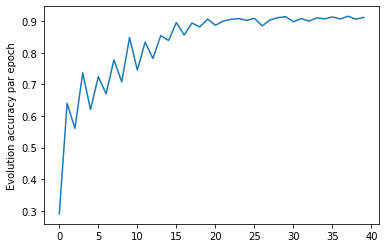

In [13]:
best_model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

## Autre test sans paramétrage du réseaux par ImageNet

In [14]:
model_ft = models.resnet101(pretrained=False)

In [15]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
class_names = image_datasets['train'].classes
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 4.6439 Acc: 0.0321
val Loss: 4.7910 Acc: 0.0442

Epoch 1/24
----------
train Loss: 3.9933 Acc: 0.0576
val Loss: 8.8683 Acc: 0.1077

Epoch 2/24
----------
train Loss: 3.7711 Acc: 0.0749
val Loss: 5.7289 Acc: 0.0996

Epoch 3/24
----------
train Loss: 3.6235 Acc: 0.0897
val Loss: 5.0730 Acc: 0.1342

Epoch 4/24
----------
train Loss: 3.5121 Acc: 0.1056
val Loss: 5.1058 Acc: 0.1416

Epoch 5/24
----------
train Loss: 3.4491 Acc: 0.1142
val Loss: 4.2005 Acc: 0.1637

Epoch 6/24
----------
train Loss: 3.3594 Acc: 0.1195
val Loss: 7.3680 Acc: 0.1534

Epoch 7/24
----------
train Loss: 3.1569 Acc: 0.1641
val Loss: 6.1092 Acc: 0.1836

Epoch 8/24
----------
train Loss: 3.1082 Acc: 0.1679
val Loss: 7.0160 Acc: 0.1976

Epoch 9/24
----------
train Loss: 3.0885 Acc: 0.1852
val Loss: 6.2088 Acc: 0.2028

Epoch 10/24
----------
train Loss: 3.0680 Acc: 0.1670
val Loss: 7.8986 Acc: 0.1836

Epoch 11/24
----------
train Loss: 3.0636 Acc: 0.1852
val Loss: 8.2328 Acc: 0.2131

Ep

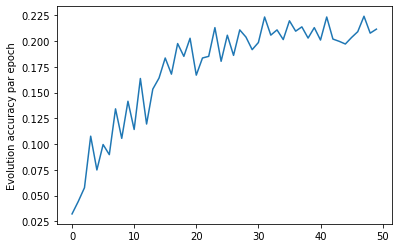

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

## Test en fixant le réseaux sauf pour la dernière couche  

In [17]:
model_conv = torchvision.models.resnet101(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
class_names = image_datasets['train'].classes
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/14
----------
train Loss: 3.4670 Acc: 0.1521
val Loss: 3.3323 Acc: 0.3783

Epoch 1/14
----------
train Loss: 2.5024 Acc: 0.3781
val Loss: 1.9032 Acc: 0.6018

Epoch 2/14
----------
train Loss: 2.0180 Acc: 0.4933
val Loss: 2.0388 Acc: 0.6519

Epoch 3/14
----------
train Loss: 1.7878 Acc: 0.5379
val Loss: 2.3282 Acc: 0.6718

Epoch 4/14
----------
train Loss: 1.5698 Acc: 0.5787
val Loss: 4.1531 Acc: 0.6475

Epoch 5/14
----------
train Loss: 1.5012 Acc: 0.6003
val Loss: 2.9598 Acc: 0.6681

Epoch 6/14
----------
train Loss: 1.3809 Acc: 0.6310
val Loss: 1.4783 Acc: 0.7139

Epoch 7/14
----------
train Loss: 1.2346 Acc: 0.6967
val Loss: 1.5170 Acc: 0.7478

Epoch 8/14
----------
train Loss: 1.1960 Acc: 0.6977
val Loss: 2.0490 Acc: 0.7323

Epoch 9/14
----------
train Loss: 1.1611 Acc: 0.7140
val Loss: 1.6730 Acc: 0.7412

Epoch 10/14
----------
train Loss: 1.1947 Acc: 0.7097
val Loss: 2.3780 Acc: 0.7235

Epoch 11/14
----------
train Loss: 1.1570 Acc: 0.7073
val Loss: 1.2048 Acc: 0.7618

Ep

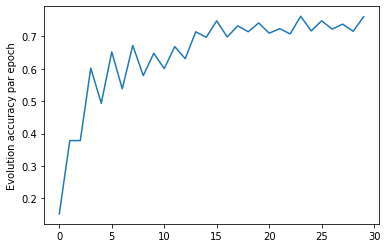

In [18]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

## Matrice de confusion du meilleur model

torch.Size([50, 50])


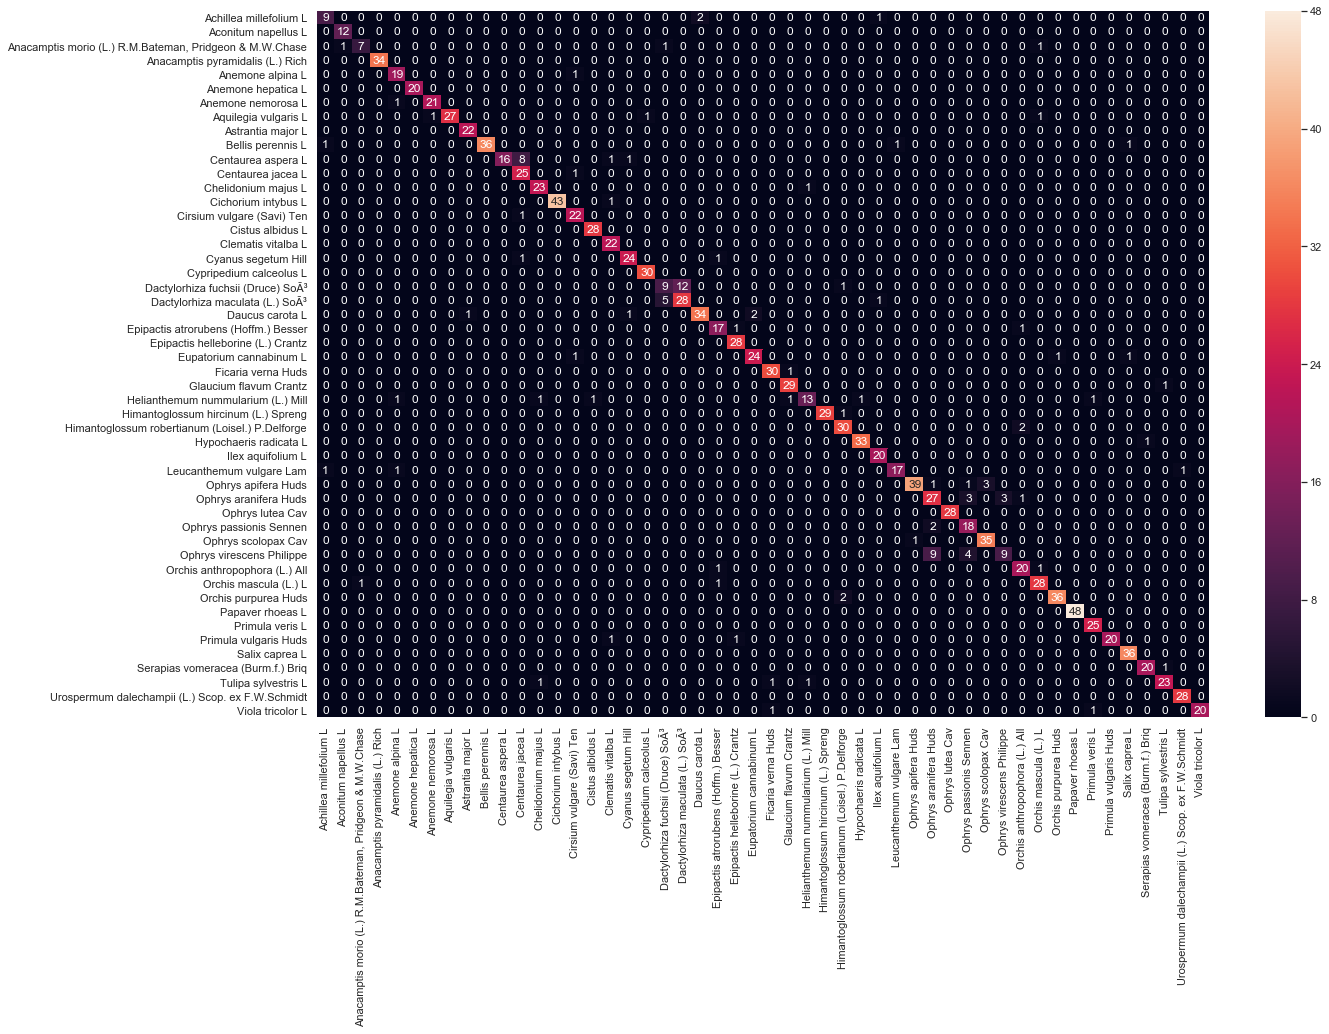

In [19]:
nb_classes = len(class_names)

normalize = False

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.shape)
# On affiche la matrice de confusion, normalisé ou non 
if normalize : 
    confusion_matrix = confusion_matrix.numpy()
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
plt.figure(figsize=(20, 13))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix, annot=True, xticklabels= class_names, yticklabels= class_names)

# correction du bug qui coupé le haut et le bas de la matrice de confusion
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show()



On constate que deux espèces se confondent : Dactylorhiza maculata (L.) SoÃ³; Dactylorhiza fuchsii (Druce) SoÃ³.
On sait que ces deux espèces ont vraiment très peu de différence entre elles en regardant les photos et du fait qu'elles sont de la même famille (Orchidaceae) et même type (Dactylorhiza).
Il est donc difficile pour le réseaux de neuronne de faire la différence.

Pareil pour Ophrys passionis Sennen, Ophrys aranifera Huds et Ophrys virescens Philippe.
On peut se poser la question de pourquoi il n'arrive pas à classifier les Ophrys virescens Philippe et que pour les deux autres espèces, les erreurs sont beaucoup moins grande.

In [20]:
# On enregistre le modèle
PATH = './CNN/bestModel.pth'
torch.save(best_model, PATH)

C:\Users\Cedric\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Cedric\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Cedric\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Cedric\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\

## Test du model sur de nouvelle valeur

In [16]:
if(not os.path.isdir('./CNN/test')):
    os.mkdir('./CNN/test')
    

for classe in y_test : 
    if(not os.path.isdir('./CNN/test/'+classe)):
        os.mkdir('./CNN/test/'+classe)

directorys=os.listdir('./CNN/test/')
for i in range(0,len(directorys)):
    files=os.listdir('./CNN/test/'+directorys[i])
    for j in range(0,len(files)):
        os.remove('./CNN/test/'+directorys[i]+'/'+files[j])


for i in range(len(X_test)):
    shutil.copyfile('./train/'+X_test[i],'./CNN/test/'+y_test[i]+'/'+X_test[i])

In [13]:
PATH = 'CNN/bestModel.pth'
our_model = torch.load(PATH)
our_model.to(device)
optimizer = optim.SGD(our_model.parameters(), lr=0.001, momentum=0.9)

In [25]:
correct = 0
total = 0
test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_data = datasets.ImageFolder('./CNN/test/', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data)


50


Accuracy of the network on test images: 90 %


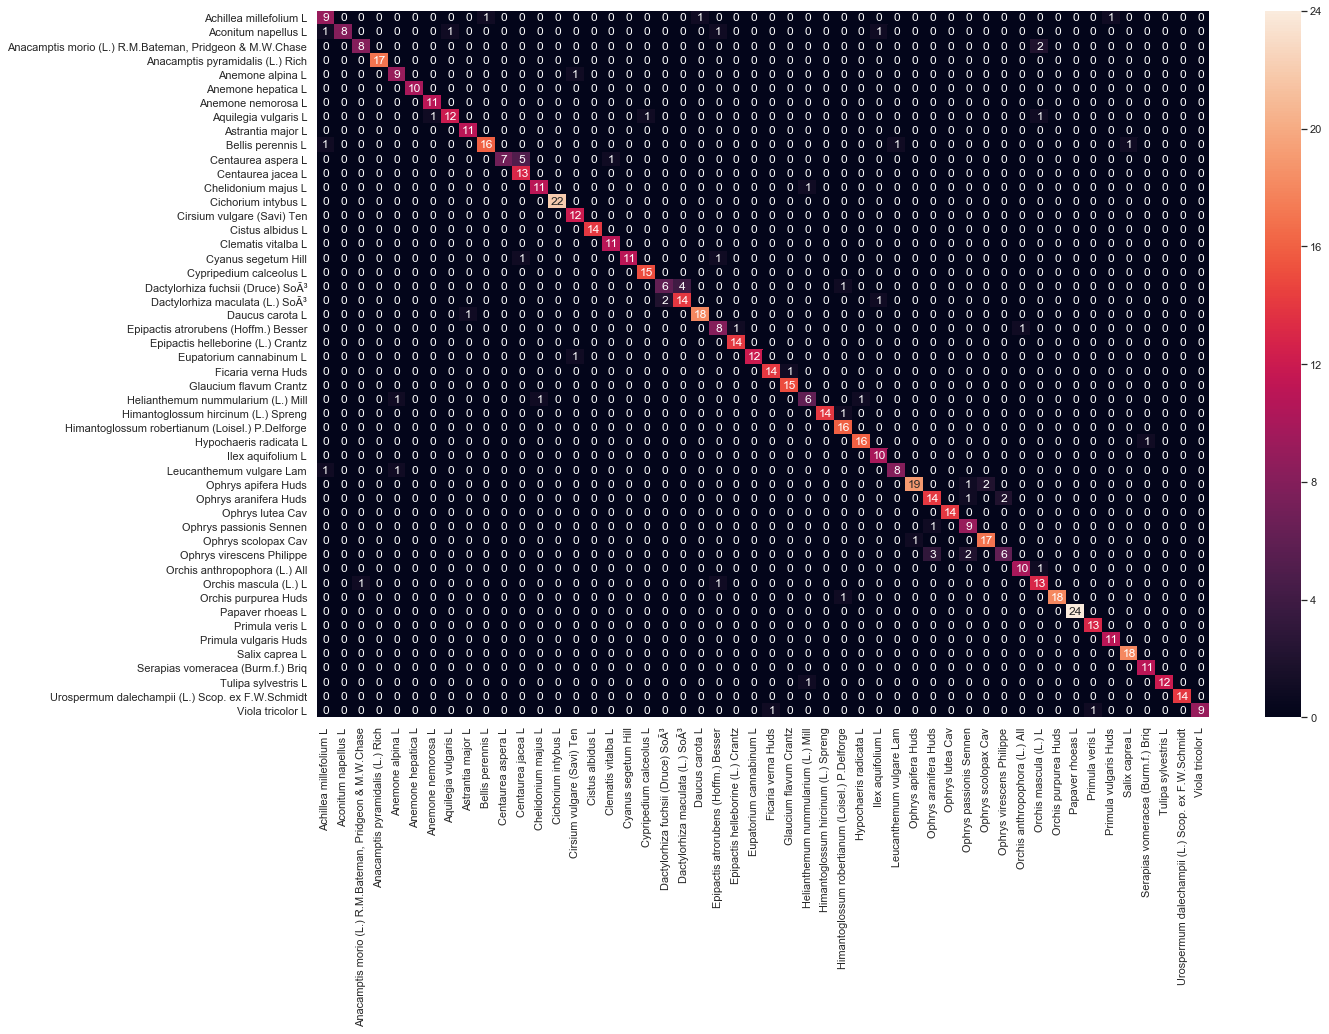

In [28]:
correct = 0
total = 0
nb_classes = len(test_data.classes)
class_names = test_data.classes
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        images = inputs.to(device)
        labels = classes.to(device)
        outputs = our_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1


print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

plt.figure(figsize=(20, 13))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix, annot=True, xticklabels= class_names, yticklabels= class_names)

# correction du bug qui coupé le haut et le bas de la matrice de confusion
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show()
